# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля.

 В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель регрессии для определения стоимости на основе входящих признаков: год регистрации автомобиля, марка, модель, мощность двигателя, тип кузова и коробки передач, пробег, вид топлива, почтовый индекс владельца, дата скачивания анкеты из базы.

Критерии оценки моделей:

- качество предсказания  (используемая метрика RMSE);
- скорость предсказания;
- время обучения.

## Подготовка данных

Загружаем библиотеки.

In [1]:
!pip install phik -q

In [2]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00


In [3]:
pip install lightgbm -q

In [4]:
pip install catboost -q

In [5]:
!pip install --user --upgrade scikit-learn -q

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import os
import time
import lightgbm as  lgb
import shap

from matplotlib import rcParams
from scipy import stats as st
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler
)

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.inspection import permutation_importance
from shap import Explanation
from shap.plots import waterfall, beeswarm
from sklearn.feature_selection import SelectKBest, f_regression

RANDOM_STATE = 42
TEST_SIZE = 0.25

Загружаем данные.

In [7]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Проверяем корректность загрузки.

In [8]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем для удобства названия столбцов к нижнему регистру и вставим в названия нижний прочерк.

In [9]:
data.columns = data.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()

Проверяем названия столбцов после преобразования.

In [10]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Теперь выведем общую информацию о датафрейме и число полных дубликатов.

In [11]:
data.info()
display(f'Дубликатов {data.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

'Дубликатов 4'

4 дубликата на 354365  записей можно удалить без потери информации.

In [12]:
data=data.drop_duplicates()

In [13]:
display(f'Дубликатов {data.duplicated().sum()}')

'Дубликатов 0'

<a id='section1'></a>
### Пропуски

Выведем общее число пропусков в таблице.

In [14]:
data.isna().sum().sort_values()

,0
date_crawled,0
price,0
registration_year,0
power,0
kilometer,0
number_of_pictures,0
brand,0
registration_month,0
postal_code,0
last_seen,0


Изучим более подробно столбцы с пропусками.

Посмотрим, какие значения принимает модель автомобиля.

In [15]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Среди моделей есть значение 'other', по-видимому для тех автомобилей, для которых модель неизвестна.

Посмотрим, сколько строк с таким значением.

In [16]:
data[data['model']=='other'].shape[0]

24420

24420 строк- довольно много, чтобы игнорировать эти значения.

Заменим пропуски в столбце 'model' на 'other', чтобы эта была одна категория неизвестных моделей.

In [17]:
data['model']=data['model'].fillna('other')

Посмотрим теперь, какую часть занимает эта категория.

In [18]:
data[data['model']=='other'].shape[0]/data.shape[0]

0.12451850493135609

12% от всех записей - автомобили категории  'other'.

Теперь рассмотрим столбец с коробкой передач.

Посмотрим, какие значения принимает столбец 'gearbox'.

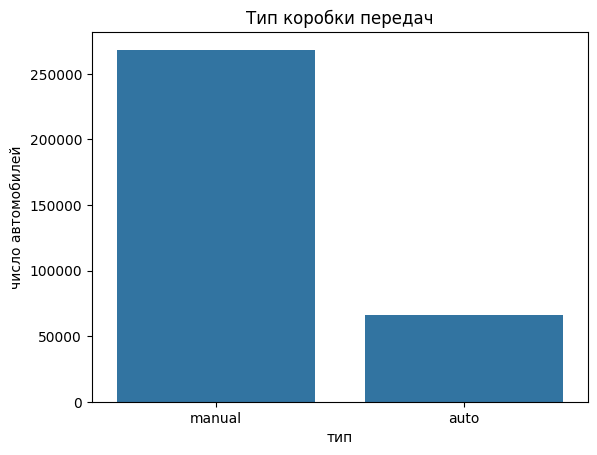

In [19]:
sns.countplot(data=data, x='gearbox')

plt.title('Тип коробки передач')
plt.xlabel('тип')
plt.ylabel('число автомобилей')
plt.show()

Точное количество машин обоих категорий выведем с помощью сводной таблицы.

In [20]:
data.pivot_table(index='gearbox', values='date_crawled',aggfunc='count')

,date_crawled
gearbox,
auto,66283
manual,268249


Заменить пропуски (их 19833 в этом столбце) на то или другое значение мы не можем, предлагается заменить их на неизвестную категорию 'unknown'.

In [21]:
data['gearbox']=data['gearbox'].fillna('unknown')

Теперь исследуем столбец 'fuel_type'.

Посмотрим, какие значения принимает этот столбец.

In [22]:
data.pivot_table(index='fuel_type', values='date_crawled',aggfunc='count').sort_values(by='date_crawled',ascending=False)

,date_crawled
fuel_type,
petrol,216349
gasoline,98719
lpg,5310
cng,565
hybrid,233
other,204
electric,90


Машин на бензине более чем в 2 раза больше, чем на газу, остальные категории на порядок меньше.

Пропусков в этом столбце 32895 - практически треть от числа машин с газовым топливом, это очень много, но в то же время отнести эти пропуски к какой-либо категории нельзя, поэтому предлагается снова заменить их на неизвестную категорию 'unknown'.

In [23]:
data['fuel_type']=data['fuel_type'].fillna('unknown')

Теперь исследуем столбец 'vehicle_type'.

In [24]:
data.pivot_table(index='vehicle_type', values='date_crawled',aggfunc='count').sort_values(by='date_crawled',ascending=False)

,date_crawled
vehicle_type,
sedan,91457
small,79830
wagon,65165
bus,28775
convertible,20203
coupe,16161
suv,11996
other,3288


Заменим пропуски в этом столбце на моду этого значения в группе по марке, модели и году.

In [25]:
data['jj']=data.groupby(['brand', 'model', 'registration_year'])['vehicle_type'].transform(lambda x: x.mode()[0] if not x.mode().empty else None)
print(data.head())

          date_crawled  price vehicle_type  registration_year gearbox  power  \
0  2016-03-24 11:52:17    480          NaN               1993  manual      0   
1  2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2  2016-03-14 12:52:21   9800          suv               2004    auto    163   
3  2016-03-17 16:54:04   1500        small               2001  manual     75   
4  2016-03-31 17:25:20   3600        small               2008  manual     69   

   model  kilometer  registration_month fuel_type       brand repaired  \
0   golf     150000                   0    petrol  volkswagen      NaN   
1  other     125000                   5  gasoline        audi      yes   
2  grand     125000                   8  gasoline        jeep      NaN   
3   golf     150000                   6    petrol  volkswagen       no   
4  fabia      90000                   7  gasoline       skoda       no   

          date_created  number_of_pictures  postal_code            last_se

In [26]:
data['vehicle_type']=data['vehicle_type'].fillna(data['jj'])

In [27]:
data=data.drop( ['jj'],
        axis=1
    )

Последним исследуем столбец с информацией, была ли машина в ремонте или нет.

In [28]:
data.pivot_table(index='repaired', values='date_crawled',aggfunc='count').\
                 sort_values(by='date_crawled',ascending=False)

,date_crawled
repaired,
no,247158
yes,36053


Пропусков в этом столбце 71154  - слишком много, чтобы отнести их к категории yes или no.

Снова заменим пропуски на 'unknown'.

In [29]:
data['repaired']=data['repaired'].fillna('unknown')

Таким образом, все пропуски в таблице (кроме столбца с моделью автомобиля) заменены на категорию 'unknown', неизвестные модели отнесены к категории 'other'.

### Исследовательский анализ данных.

#### Рассмотрим числовые переменные датафрейма.

Начнем с года регистрации автомобиля.

Выведем все уникальные значения этой переменной.

In [30]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Посмотрим на последнюю дату скачивания анкеты.

In [31]:
 data['date_crawled'].max()

'2016-04-07 14:36:58'

Последняя анкета была скачана 7 апреля 2016 года.
    
Значит, годы регистрации с 2017 по 2019 являются также ошибочными.
    
За 2017 год можно оставить те записи, в которых месяц регистрации меньше 4.    

In [32]:
data=data[(data['registration_year']<2016) | ((data['registration_year']==2016) & (data['registration_month']<4))]

Очевидно, все значения года больше 2019 являются ошибочными.

Поскольку массовое промышленное производство автомобилей началось в 1930-ых годах, то год регистрации не может быть меньше 1930.

Более того, все значения меньше 1960 скорее всего либо ошибочные, либо редкие раритетные модели.

Посмотрим, какую часть от общего объема данных они занимают.

In [33]:
data_bad=data[data['registration_year']<1960]
data_bad.shape[0]
data_bad.shape[0]/data.shape[0]

0.001261686294558903

Меньше 1 процента, поэтому эти данные можно удалить, чтобы не портить модель.

In [34]:
data=data[data['registration_year']>1960]

Теперь можно построить гистограмму значений года регистрации.

<ipython-input-35-7c46944c6c6f>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax. set_xticklabels (ax.get_xticklabels (), rotation= 90 )


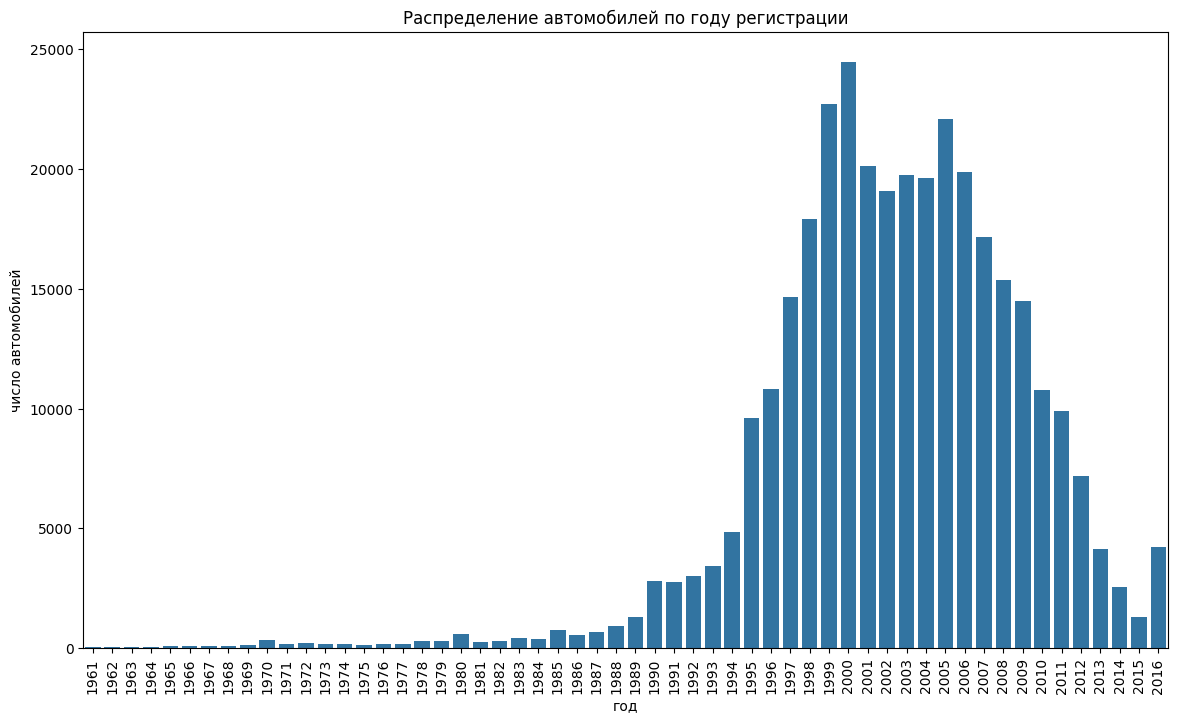

In [35]:
plt.figure(figsize=(14,8))

ax=sns.countplot(data=data, x='registration_year')
ax. set_xticklabels (ax.get_xticklabels (), rotation= 90 )

plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('год')
plt.ylabel('число автомобилей')
plt.show()

Большинство машин зарегистрировано между 1990 и 2019 годами, распределение похоже на нормальное, если не считать скачок за 2016-2018 год.

Следующий числовой признак - мощность двигателя.

Рассмотрим значения, которые принимает столбец 'power'.

In [36]:
data['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Маломощные автомобили в 10 л.с. существуют, но мощности в 2000 л.с. пока еще никто не достигал.

В основном, мощности двигателей современных автомобилей не превосходят 500 л.с.

Посмотрим, сколько значений больше 500 в датафрейме.

In [37]:
data_bad=data[(data['power']>500)]

data_bad.shape[0]/data.shape[0]

0.0012160676684747935

Такое малое количество записей можно удалить без потери важной информации.

In [38]:
data=data[data['power']<500]

Построим гистограмму распределения автомобилей по мощности.

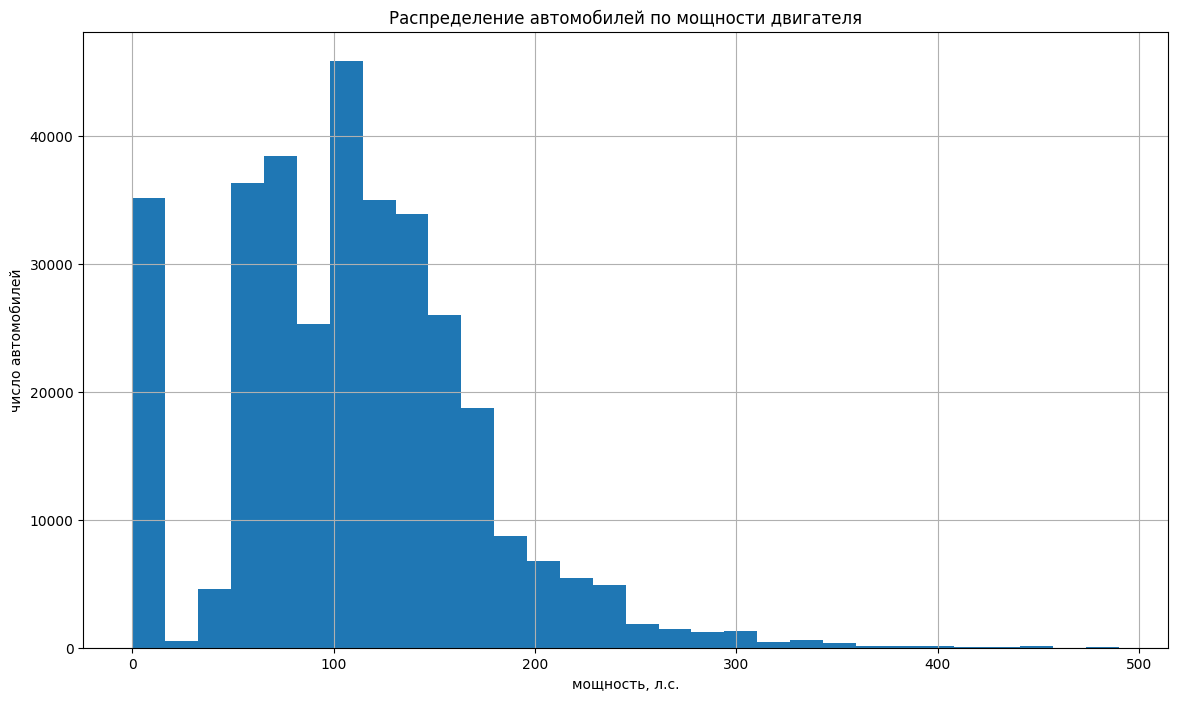

In [39]:
plt.figure(figsize=(14,8))

data['power'].hist(bins=30)

plt.title('Распределение автомобилей по мощности двигателя')
plt.xlabel('мощность, л.с.')
plt.ylabel('число автомобилей')
plt.show()

Из гистограммы видно, что много нулевых значений, оценим их точное количество.

In [40]:
data_bad=data[(data['power']==0)]
data_bad.shape[0]

34836

Почти 40000 нулевых значений, явно ошибочных - это очень много.

Если не считать этот "скачок" в нуле, распределение машин по мощности выглядит как нормальное, поэтому большой ошибки не будет, если мы заменим нулевые значения на среднее.

Рассчитаем это среднее.

In [41]:
data1=data[data['power']>0]
display(data1['power'].describe())

,power
count,298587.000000
mean,120.624793
std,53.473527
min,1.000000
25%,75.000000
50%,111.000000
75%,150.000000
max,490.000000


Заменим нули на пропуски.

In [42]:
data.loc[data['power'] == 0, 'power'] = np.nan

Теперь заменим нули на среднее значение в группе той же модели.

In [43]:
for t in data['model'].unique():
    data.loc[(data['model']==t)&(data['power'].isna()),'power']=\
        data.loc[(data['model']==t),'power'].mean()

In [44]:
data=data.dropna(subset=['power'])

Построим теперь гистограмму для мощности двигателя.

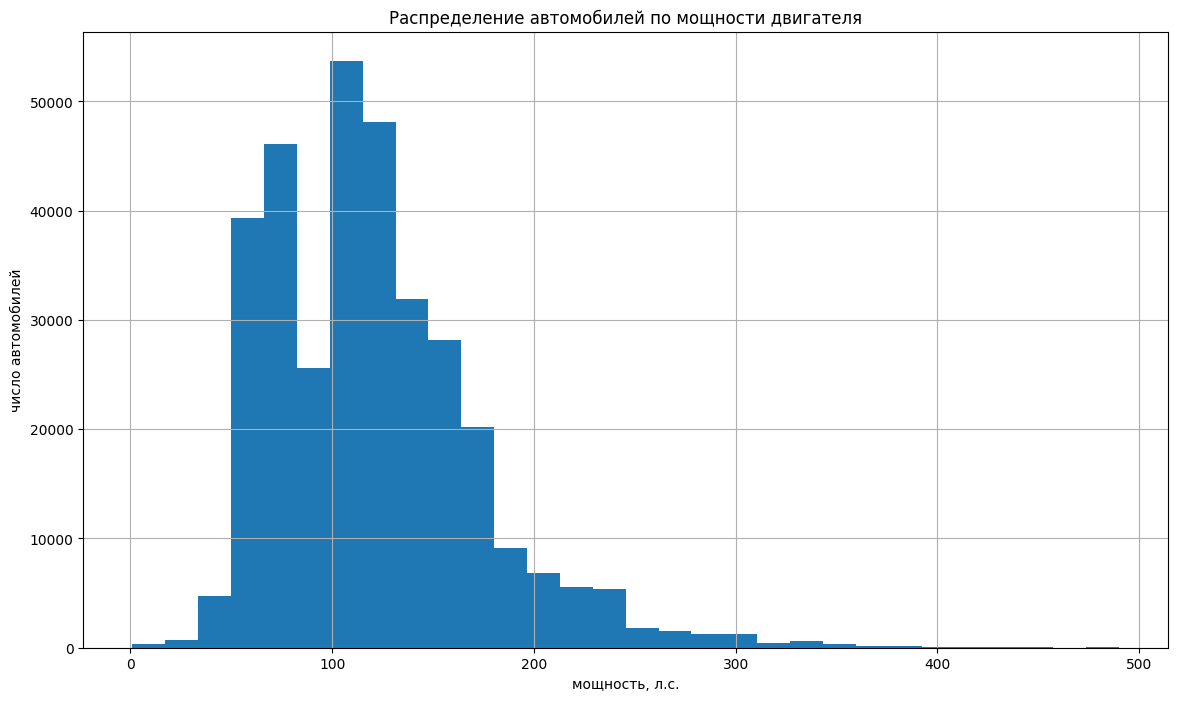

In [45]:
plt.figure(figsize=(14,8))

data['power'].hist(bins=30)

plt.title('Распределение автомобилей по мощности двигателя')
plt.xlabel('мощность, л.с.')
plt.ylabel('число автомобилей')
plt.show()

Теперь значения мощности выглядят правдоподобными.

Рассмотрим значения пробега автомобилей.

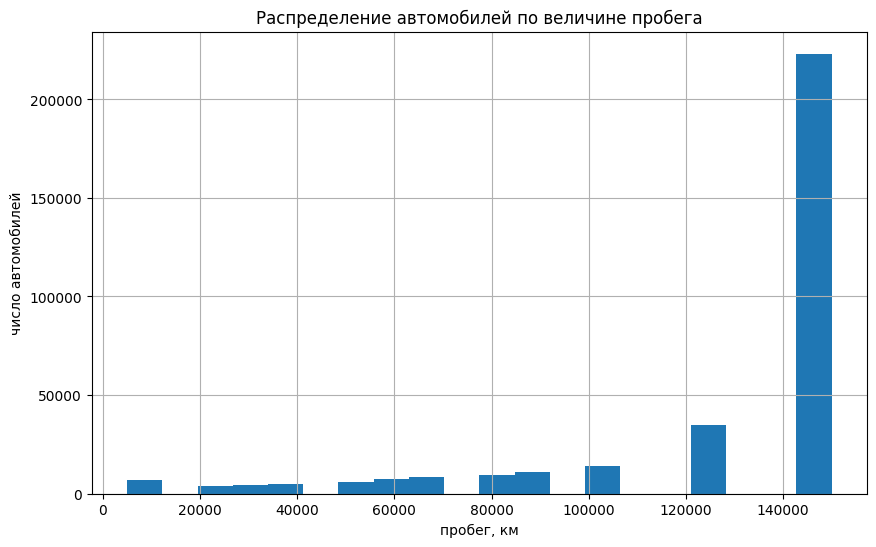

In [46]:
data['kilometer'].hist(bins=20,figsize=(10, 6))
plt.title('Распределение автомобилей по величине пробега')
plt.xlabel('пробег, км')
plt.ylabel('число автомобилей')
plt.show()

Судя по гистограмме, пробег принимает дискретные значения.

Выведем все уникальные значения пробега.

In [47]:
data['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000, 100000,  60000,
         5000,  20000,  80000,  50000,  10000])

Действительно, значения пробега ограничены набором значений, поэтому можно считать пробег категориальной переменной.

Месяц регистрации формально является численной переменной, но по сути тоже является категориальной.

Построим гистограмму значений для месяца регистрации.

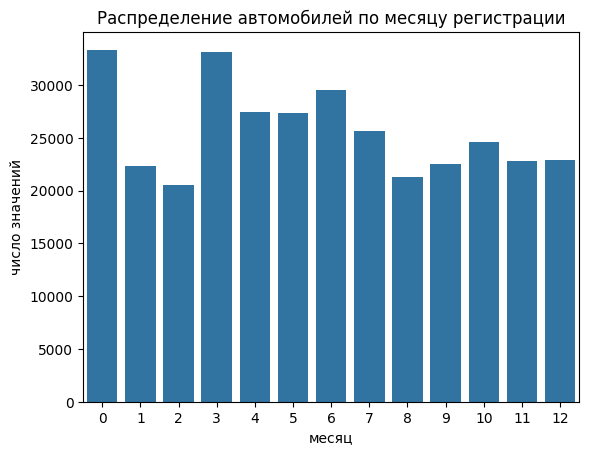

In [48]:
sns.countplot(data=data, x='registration_month')

plt.title('Распределение автомобилей по месяцу регистрации')
plt.xlabel('месяц')
plt.ylabel('число значений')
plt.show()

Из гистограммы видно, что столбец с месяцем регистрации содержит много нулевых значений. Заменять нули не будем, их примерно столько же, сколько зарегистрированных автомобилей в каждый месяц, а в целом распределение машин по месяцам равномерное (исключая январь и февраль). Этот признак категориальный, "0" будет дополнительной категорией.

Теперь исследуем количество фотографий.

Посмотрим, какие значения принимает эта переменная.

In [49]:
data['number_of_pictures'].unique()

array([0])

Число фотографий принимает только нулевые значения, значит она не представляет интерес для нашей модели, можно ее удалить из датафрейма.

In [50]:
data=data.drop(['number_of_pictures'],axis=1)

Посмотрим, сколько разных значений принимает почтовый индекс.

In [51]:
data['postal_code'].nunique()

8135

In [52]:
data['postal_code'].unique()

array([70435, 66954, 90480, ..., 89446, 38528, 38325])

Почтовый индекс тоже можно отнести к категориальным переменным. Но значений у него слишком много, модель будет долго обучаться, поэтому исключим его из признаков вовсе.

Теперь рассмотрим строковые переменные, которые , конечно, являются категориальными.

#### Категориальные переменные

Построим категориальные гистограммы для типа кузова, коробки передач, типа топлива, марки и индикатора, была ли машина в ремонте.

Модели автомобилей были рассмотрены в [п.1.1](#section1), их очень много, чтобы строить для них категориальную гистограмму.

Построим категориальную гистограмму для типа кузова.

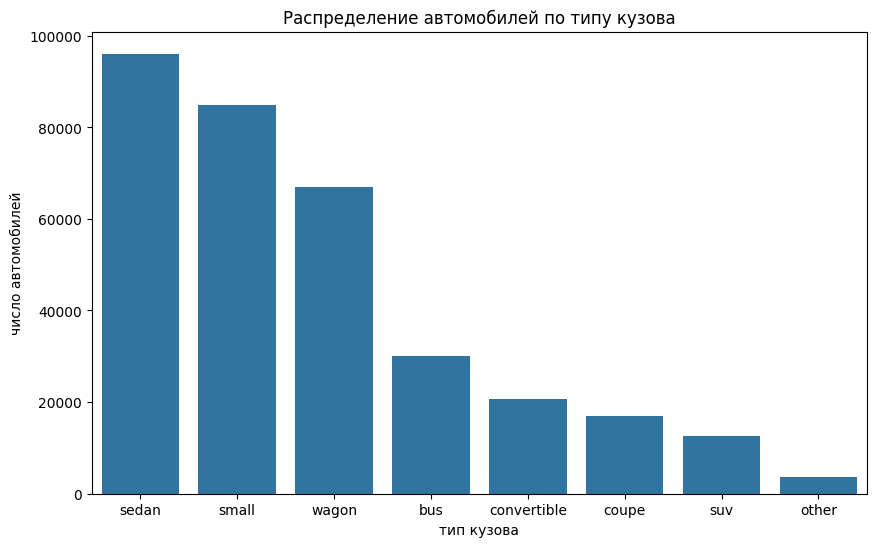

In [53]:
plt.figure(figsize=(10,6))

sns.countplot(data=data, x='vehicle_type',order=data['vehicle_type'].value_counts(ascending=False).index)

plt.title('Распределение автомобилей по типу кузова')
plt.xlabel('тип кузова')
plt.ylabel('число автомобилей')
plt.show()

Самый распространенный тип кузова - седан, затем идут малолитражки и автофургоны, категория неизвестных оказалась на 4 месте, то есть составляет внушительную долю данных.

Построим категориальную гистограмму для коробки передач.

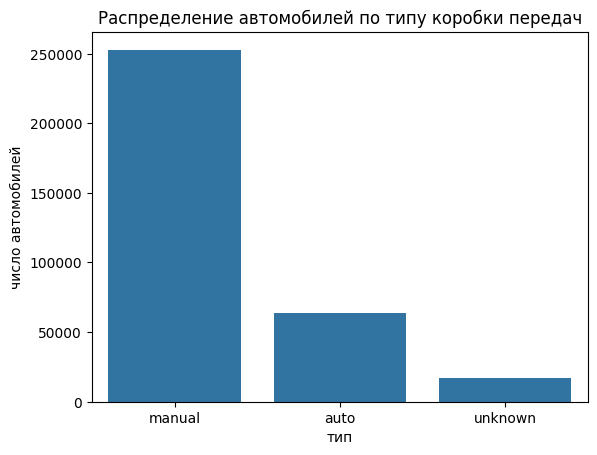

In [54]:
sns.countplot(data=data, x='gearbox')

plt.title('Распределение автомобилей по типу коробки передач')
plt.xlabel('тип')
plt.ylabel('число автомобилей')
plt.show()

Большинство автомобилей имеет ручную коробку передач, автоматов примерно в 4 раза меньше, и прибавилась категория неизвестной коробки.

Построим категориальную гистограмму для типа топлива.

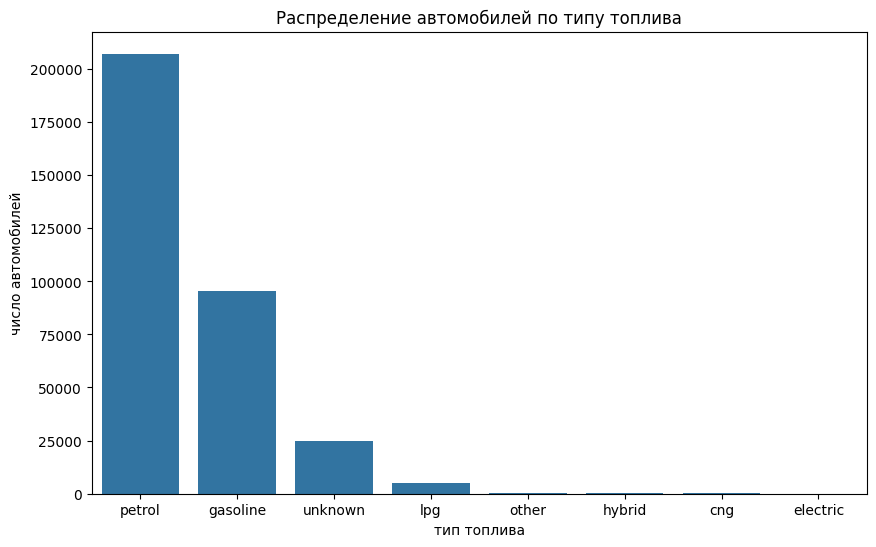

In [55]:
plt.figure(figsize=(10,6))

sns.countplot(data=data, x='fuel_type')

plt.title('Распределение автомобилей по типу топлива')
plt.xlabel('тип топлива')
plt.ylabel('число автомобилей')
plt.show()

Большинство автомобилей ездит на бензине, затем на газу в 2 раза меньше, и новая неизвестная категория занимает теперь большую долю от наблюдений.

Построим категориальную гистограмму для марки автомобиля.

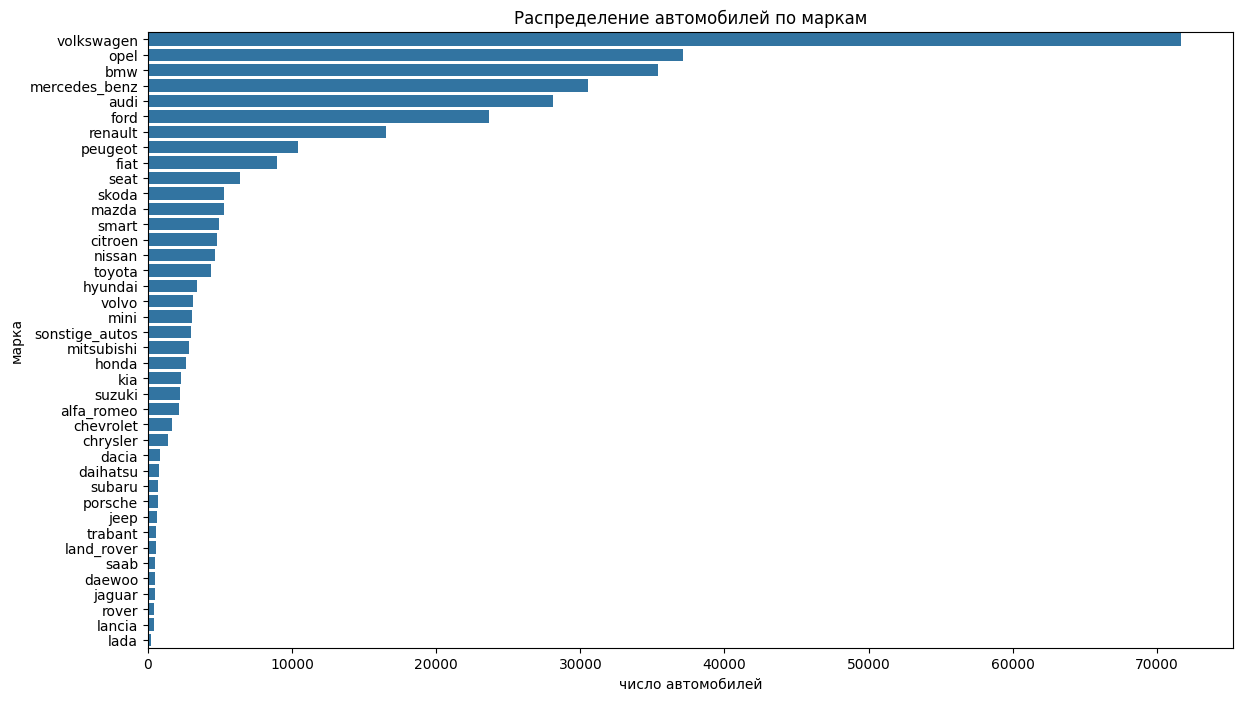

In [56]:
plt.figure(figsize=(14,8))

sns.countplot(data=data, y='brand',orient='h',order=data['brand'].value_counts(ascending=False).index)

plt.title('Распределение автомобилей по маркам')
plt.xlabel('число автомобилей')
plt.ylabel('марка')
plt.show()

Самая популяргая марка - volkswagen,затем  opel и bmv.

Построим категориальную гистограмму для пребывания машины в ремонте.

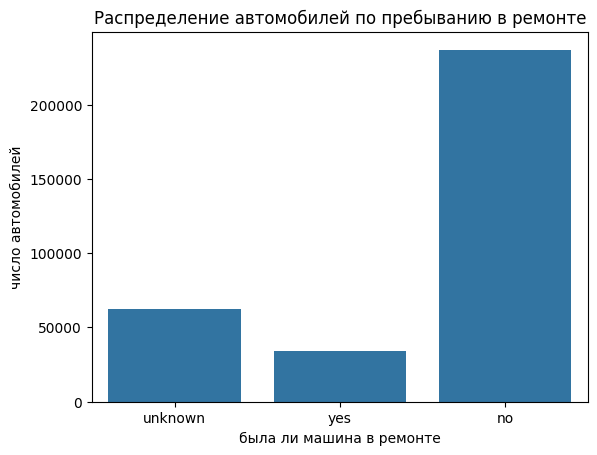

In [57]:
sns.countplot(data=data, x='repaired')

plt.title('Распределение автомобилей по пребыванию в ремонте')
plt.xlabel('была ли машина в ремонте')
plt.ylabel('число автомобилей')
plt.show()

Большинство машин не было в ремонте, неуказанных машин очень много - больше, чем тех, что были в ремонте.

Исследуем распределение целевого признака - цены автомобилей.

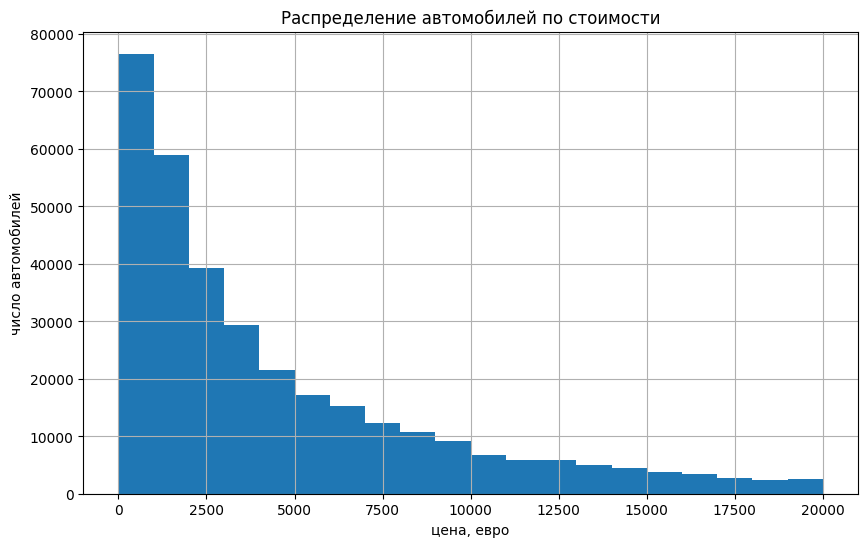

In [58]:
plt.figure(figsize=(10,6))
data['price'].hist(bins=20)

plt.title('Распределение автомобилей по стоимости')
plt.xlabel('цена, евро')
plt.ylabel('число автомобилей')
plt.show()

Опять мы видим много нулевых значений. Оценим их долю среди всех наблюдений.

In [59]:
data[data['price']==0].shape[0]/data.shape[0]

0.02877443232429871

Почти 3% явно ошибочных данных, но в данном случае распределение не похоже на нормальное, заменить нули средним значением будет некорректно.

Поэтому, несмотря на то, что 3% - это много, удалим данные с нулевой ценой, чтобы не испортить нашу модель предсказаний.

In [60]:
data=data[data['price']>0]

<a id='section2'></a>
#### Корреляционный анализ

Рассчитаем коэффициенты корреляции Фи между всеми признаками (числовыми и категориальными) средствами библиотеки phik.

В числовые переменные включим только цену и мощность двигателя, другие численные переменные по сути являются категориальными.

Из расчетов исключим еще переменные с датами и почтовый индекс, поскольку они принимают слишком много значений, phik не может рассчитать коэффициенты корреляции для них.

In [61]:
data1=data.drop(['date_crawled','date_created','postal_code','last_seen'],axis=1)
data1.phik_matrix(interval_cols=['price','power']).style.background_gradient(cmap="RdYlGn")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
price,1.000000,0.270886,0.670450,0.303847,0.482941,0.572027,0.324707,0.163937,0.270093,0.362532,0.358542
vehicle_type,0.270886,1.000000,0.287613,0.236623,0.484433,0.910832,0.186905,0.090888,0.450768,0.637564,0.110985
registration_year,0.670450,0.287613,1.000000,0.295254,0.288018,0.673359,0.625747,0.294017,0.421063,0.370662,0.362878
gearbox,0.303847,0.236623,0.295254,1.000000,0.461368,0.623640,0.171842,0.335764,0.352344,0.515859,0.454928
power,0.482941,0.484433,0.288018,0.461368,1.000000,0.789663,0.120261,0.057350,0.240770,0.599899,0.105407
model,0.572027,0.910832,0.673359,0.623640,0.789663,1.000000,0.435447,0.192657,0.538557,0.997805,0.264583
kilometer,0.324707,0.186905,0.625747,0.171842,0.120261,0.435447,1.000000,0.160582,0.191969,0.277264,0.217829
registration_month,0.163937,0.090888,0.294017,0.335764,0.057350,0.192657,0.160582,1.000000,0.283416,0.102145,0.396949
fuel_type,0.270093,0.450768,0.421063,0.352344,0.240770,0.538557,0.191969,0.283416,1.000000,0.334775,0.265495
brand,0.362532,0.637564,0.370662,0.515859,0.599899,0.997805,0.277264,0.102145,0.334775,1.000000,0.151497


Как видно из таблицы, цена имеет заметную корреляцию по шкале Чеддока с годом выпуска (0.67) и моделью (0.58),

умеренную корреляцию с мощностью двигателя (0.47), маркой (0.36), ремонтом(0.36), километражом (0.32) и коробкой передач (0.3).

Слабая корреляция наблюдается с типом топлива, кузова и месяцем регистрации.

Из таблицы еще можно увидеть сильную мультиколлинеарность между признаками "марка", "модель" и "тип кузова".
    
Объединим марку и модель в один признак brand_model, чтобы упростить нам обучение моделей.
    
Тип кузова является избыточным признаком, поэтому исключим его из рассмотрения.

In [62]:
data['brand_model']=data['brand']+'_'+data['model']

In [63]:
display(data.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,brand_model
0,2016-03-24 11:52:17,480,sedan,1993,manual,104.461068,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,70435,2016-04-07 03:16:57,volkswagen_golf
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.000000,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50,audi_other
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.000000,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,90480,2016-04-05 12:47:46,jeep_grand
3,2016-03-17 16:54:04,1500,small,2001,manual,75.000000,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17,volkswagen_golf
4,2016-03-31 17:25:20,3600,small,2008,manual,69.000000,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21,skoda_fabia


Таким образом, исследовательский анализ выявил в данных существенные недостатки: большое количество явно ошибочных нулевых значений, а так же аномально высокие значения некоторых переменных.

Все недостатки данных устранены, данные готовы к работе.

## Обучение моделей

Будем работать с 4 моделями: DecisionTreeRegressor, SGDRegressor, CatBoost и LightGBM.

Для всех этих моделей категориальные признаки будем кодировать по-разному:

для DecisionTree будем использовать  OrdinalEncoder,
для SGDRegressor - OneHotEncoder,
CatBoost и LightGBM имеют свои встроенные встроенные кодировщики.

Для каждой модели с помощью случайного поиска с кросс-валидацией на 5 выборках проведем подбор гиперпараметров.

Все кросс-валидационные показатели для каждой модели сохраним, чтобы затем вывести их в одной таблице.

Выбор наилучшей модели произведем на основе сравнения валидационных метрик RSME.

Итак, выделяем обучающую и тестовую выборки в соотношении 3:1.

Из признаков, помимо числа фотографий, исключим все даты и почтовый код: если их кодировать, будет слишком много категорий, время обучения модели может увеличиться многократно.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(
        ['date_crawled','date_created','postal_code','last_seen','price','brand','model','vehicle_type','registration_month'],
        axis=1
    ),
    data['price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

Выделяем категориальные и количественные признаки.

In [65]:
#категориальные признаки
ord_columns = [
     'gearbox','brand_model','fuel_type','repaired'
]

#количественные признаки
num_columns = ['registration_year','kilometer','power']


### Подбор гиперпараметров для DecisionTreeRegressor

Создаём пайплайн для подготовки признаков из списка ohe_columns с помощью OrdinalEncoder (неизвестные значения будем игнорировать, пропуски заполнять самым часто встречающимся значением.).

In [66]:
ord_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Числовые категории масштабируем с помощью StandardScaler.

Пайплайн для подготовки данных:

In [67]:
data_preprocessor = ColumnTransformer(
   transformers = [
     ('ord', ord_pipe, ord_columns),
      ('num', StandardScaler(), num_columns)
   ])

Словарь с гиперпараметрами модели:

In [68]:
param_distributions = [

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': range(2, 10),
        'models__min_samples_split': range(2, 10),

    }
]

Итоговый пайплайн:

In [69]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Подбор гиперпараметров методом случайного поиска:

In [70]:
rs = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=1000,
    cv=5
)

In [71]:
start = time.perf_counter()

rs.fit(X_train, y_train)

end=time.perf_counter()
elapsed =end - start  # Останавливаем таймер
print(f"Затрачено времени: {elapsed} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 64 is smaller than n_iter=1000. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Затрачено времени: 92.00336749100006 сек


Результаты подбора гиперпараметров (лучшая метрика, среднее время обучения и предсказания и параметры модели):

In [72]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(rs.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','mean_fit_time','mean_score_time','params']
].sort_values('rank_test_score'))


,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
48,1,DecisionTreeRegressor(random_state=42),-1828.205390,0.916645,0.081539,"{'models__min_samples_split': 2, 'models__min_samples_leaf': 8, 'models': DecisionTreeRegressor(random_state=42)}"
49,1,DecisionTreeRegressor(random_state=42),-1828.205390,0.906735,0.077268,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 8, 'models': DecisionTreeRegressor(random_state=42)}"
50,1,DecisionTreeRegressor(random_state=42),-1828.205390,0.910666,0.079444,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 8, 'models': DecisionTreeRegressor(random_state=42)}"
51,1,DecisionTreeRegressor(random_state=42),-1828.205390,0.912353,0.081064,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 8, 'models': DecisionTreeRegressor(random_state=42)}"
52,1,DecisionTreeRegressor(random_state=42),-1828.205390,0.904343,0.079897,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 8, 'models': DecisionTreeRegressor(random_state=42)}"
...,...,...,...,...,...,...
4,60,DecisionTreeRegressor(random_state=42),-1898.915460,1.137448,0.081243,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=42)}"
3,61,DecisionTreeRegressor(random_state=42),-1908.323999,1.365699,0.131670,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=42)}"
2,62,DecisionTreeRegressor(random_state=42),-1918.569746,1.074951,0.109886,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=42)}"
0,62,DecisionTreeRegressor(random_state=42),-1918.569746,0.937851,0.085862,"{'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models': DecisionTreeRegressor(random_state=42)}"


Сохраняем метрику, время обучения и предсказания, и саму модель.

In [73]:
time_1_best=result['mean_fit_time'][result['rank_test_score']==1].iloc[0]
time_2_best=result['mean_score_time'][result['rank_test_score']==1].iloc[0]
metrics_best=-result['mean_test_score'][result['rank_test_score']==1].iloc[0]

In [74]:
best_model_DecisionTree =rs.best_estimator_

In [75]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_)

Лучшая модель и её параметры:

 {'models__min_samples_split': 2, 'models__min_samples_leaf': 8, 'models': DecisionTreeRegressor(random_state=42)}


Лучшими параметрами по результатом поиска оказались 'min_samples_split': 2, 'min_samples_leaf': 8 .

### Подбор гиперпараметров для стохастического градиентного спуска для линейной регрессии SGDRegressor

In [76]:
#категориальные признаки
ohe_columns = [
     'gearbox','brand_model','fuel_type','repaired'
]

In [77]:
#пайплайн для кодирования категориальных признаков
ohe_pipe = Pipeline(
    [
         (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
             OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
         )
    ]
)

In [78]:
#пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],

)

In [79]:
#итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [80]:
#словарь гиперпараметров модели
param_distributions = {

    'models' : [SGDRegressor(random_state=RANDOM_STATE, early_stopping = True)],
    'models__max_iter': [100, 200],
}

In [81]:
#случайный поиск для подбора гиперпараметров
rs = RandomizedSearchCV(
    pipe_final,
    param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [82]:
start = time.perf_counter()

rs.fit(X_train, y_train)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Затрачено времени: 21.15921926299984 сек


In [83]:
#результаты случайного поиска
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(rs.cv_results_)
display(result[
    ['rank_test_score',  'mean_test_score','mean_fit_time','mean_score_time','params']
].sort_values('rank_test_score'))


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1,-2711.80504,4.532562,0.243463,"{'models__max_iter': 100, 'models': SGDRegressor(early_stopping=True, random_state=42)}"
1,1,-2711.80504,4.268006,0.242939,"{'models__max_iter': 200, 'models': SGDRegressor(early_stopping=True, random_state=42)}"


In [84]:
#запоминаем время обучения, предсказания, метрику и модель
time_1_rs_SGD=result['mean_fit_time'][result['rank_test_score']==1].iloc[0]
time_2_rs_SGD=result['mean_score_time'][result['rank_test_score']==1].iloc[0]
metrics_rs_SGD=-result['mean_test_score'][result['rank_test_score']==1].iloc[0]

In [85]:
best_model_SGD = rs.best_estimator_

In [86]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_)

Лучшая модель и её параметры:

 {'models__max_iter': 100, 'models': SGDRegressor(early_stopping=True, random_state=42)}


### Подбор гиперпараметров для градиентного бустинга библиотекой CatBoost

In [87]:
#словарь гиперпараметров модели
params = {

    'depth': [4,10],
    'learning_rate': [0.01,0.05]
}

In [88]:
#категориальные признаки
cat_features = [
      'gearbox','fuel_type','brand_model','repaired'
]

In [89]:
#инициация модели
regressor = CatBoostRegressor(iterations=100, random_state=RANDOM_STATE, thread_count=-1, early_stopping_rounds=20)

In [90]:
#случайный поиск для подбора гиперпараметров
rs = RandomizedSearchCV(
    regressor,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE
)

In [91]:
#обучение случайного поиска
start = time.perf_counter()

rs.fit(X_train, y_train, cat_features=cat_features, verbose=False)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Затрачено времени: 30.557617748999974 сек


In [92]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_)

Лучшая модель и её параметры:

 {'learning_rate': 0.05, 'depth': 10}


In [93]:
#вывод результатов случайного поиска
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(rs.cv_results_)
display(result[
    ['rank_test_score',  'mean_test_score','mean_fit_time','mean_score_time','params']
].sort_values('rank_test_score'))


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
3,1,-1881.028034,9.054833,0.108757,"{'learning_rate': 0.05, 'depth': 10}"
1,2,-2107.854031,5.201365,0.145896,"{'learning_rate': 0.05, 'depth': 4}"
2,3,-2681.469197,10.954669,0.237346,"{'learning_rate': 0.01, 'depth': 10}"
0,4,-2958.041179,5.303727,0.169118,"{'learning_rate': 0.01, 'depth': 4}"


In [94]:
#сохранение результатов поиска
time_1_rs_catboost=result['mean_fit_time'][result['rank_test_score']==1].iloc[0]
time_2_rs_catboost=result['mean_score_time'][result['rank_test_score']==1].iloc[0]
metrics_rs_catboost=-result['mean_test_score'][result['rank_test_score']==1].iloc[0]

In [95]:
best_model_CatBoost = rs.best_estimator_

In [96]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_)

Лучшая модель и её параметры:

 {'learning_rate': 0.05, 'depth': 10}


### Подбор гиперпараметров для градиентного бустинга библиотекой LightGBM

In [97]:
#словарь гиперпараметров модели
params = {

    'max_depth': range(4, 6),

 }

In [98]:
#категориальные признаки
categorical_feature = [
     'gearbox','brand_model','fuel_type','repaired'
]

In [99]:
#перевод категориальных признаков в тип category
for c in categorical_feature:
    X_train[c] = X_train[c].astype('category')
    X_test[c]=X_test[c].astype('category')

In [100]:
#инициация модели
regressor=LGBMRegressor(objective='regression',random_state=RANDOM_STATE,n_jobs=-1)

In [101]:
#случайный поиск для подбора гиперпараметров
rs = RandomizedSearchCV(
    regressor,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    n_iter=10,
    error_score='raise',
    random_state=RANDOM_STATE
)

In [102]:
#обучение случайного поиска
start = time.perf_counter()

rs.fit(X_train, y_train, categorical_feature=categorical_feature)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 242870, number of used features: 7
[LightGBM] [Info] Start training from score 4638.171030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [103]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_)

Лучшая модель и её параметры:

 {'max_depth': 5}


In [104]:
#вывод результатов поиска
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(rs.cv_results_)
display(result[
    ['rank_test_score',  'mean_test_score','mean_fit_time','mean_score_time','params']
].sort_values('rank_test_score'))


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
1,1,-1717.794849,1.350737,0.423717,{'max_depth': 5}
0,2,-1764.985101,1.523843,0.596739,{'max_depth': 4}


In [105]:
#сохранение результатов поиска
time_1_rs_LGBM=result['mean_fit_time'][result['rank_test_score']==1].iloc[0]
time_2_rs_LGBM=result['mean_score_time'][result['rank_test_score']==1].iloc[0]
metrics_rs_LGBM=-result['mean_test_score'][result['rank_test_score']==1].iloc[0]

In [106]:
best_model_LGBM = rs.best_estimator_

In [107]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_)

Лучшая модель и её параметры:

 {'max_depth': 5}


## Анализ моделей

Теперь можем представить таблицу сравнения моделей:  выводим лучшие найденные модели с параметрами из таблиц cv_results_ для каждого поиска.


</div>


In [108]:
data_model = [
    ['Лучшая модель DecisionTreeRegressor',time_1_best, time_2_best, metrics_best],
    ['Лучшая модель SGD',time_1_rs_SGD, time_2_rs_SGD, metrics_rs_SGD],
    ['Лучшая модель CatBoost', time_1_rs_catboost, time_2_rs_catboost, metrics_rs_catboost],
    ['Лучшая модель LightGBM', time_1_rs_LGBM, time_2_rs_LGBM,metrics_rs_LGBM],
]
df = pd.DataFrame(data_model,columns=['Модель','Время обуч.','Время предск.','RMSE'])

display(df)

,Модель,Время обуч.,Время предск.,RMSE
0,Лучшая модель DecisionTreeRegressor,0.916645,0.081539,1828.205390
1,Лучшая модель SGD,4.532562,0.243463,2711.805040
2,Лучшая модель CatBoost,9.054833,0.108757,1881.028034
3,Лучшая модель LightGBM,1.350737,0.423717,1717.794849


Лучшей по метрике оказалась LightGBM, а по времени обучения и предсказания  - DecisionTreeRegressor, но у нее метрика RMSE сильно больше, чем у LightGBM, а время обучения LightGBM 7.8 сек является вполне адекватным.

Поэтому LightGBM признаем лучшей моделью, и для нее рассчитаем метрику на тестовой выборке.

In [109]:
y_pred=best_model_LGBM.predict(X_test)
print(f'Метрика на тестовой выборке: {root_mean_squared_error(y_pred,y_test)}')

Метрика на тестовой выборке: 1701.9896300909872


##  Анализ остатков наилучшей модели

Проанализируем остатки найденной лучшей модели.

count    80957.000000
mean         2.911071
std       1701.997652
min     -16671.770231
25%       -680.784208
50%        -90.611363
75%        567.269595
max      18346.171718
Name: price, dtype: float64


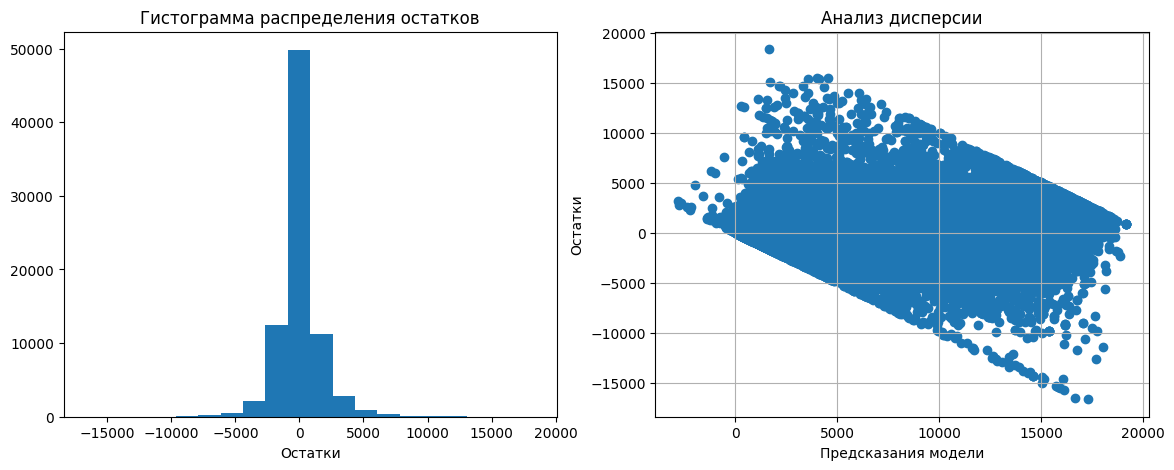

In [110]:
# остатки
residuals = y_test-y_pred
print(residuals.describe())

# построение гистограммы частотности и диаграмму рассеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].hist(residuals, bins = 20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred, y=residuals)
axes[1].grid()
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Остатки (разности между истинными и предсказанными значениями)в целом распределены симметрично относительно 0.
Из точечной диаграммы остатков/ предсказаний видно, что для предсказаний до 10000 больше положительных остатков, а для предсказаний больше 10000 больше отрицательных остатков. Значит, наша модель занижает стоимость для более дешевых моделей, и завышает для более дорогих.

## Анализ признаков, наиболее значимых для модели

Самый простой показатель для оценки важности признаков в моделях без встроенных весов является permutation importance, «важность после перестановки». Его применим к нашей лучшей модели.

In [111]:
#вычисление коэффициентов важности признаков
results = permutation_importance(best_model_LGBM, X_test, y_test, n_repeats=10, random_state = RANDOM_STATE)

In [112]:
#создание таблицы для удобного отображения вычисленных коэффициентов
imp=[]
for i, importance in enumerate(results.importances_mean):
    imp.append(importance)

In [113]:
table = pd.DataFrame({
    'imp': imp,
    'columns': X_train.columns
})

        imp            columns
0  0.709465  registration_year
2  0.310074              power
6  0.140521        brand_model
3  0.082698          kilometer
5  0.030178           repaired
1  0.007187            gearbox
4  0.005591          fuel_type


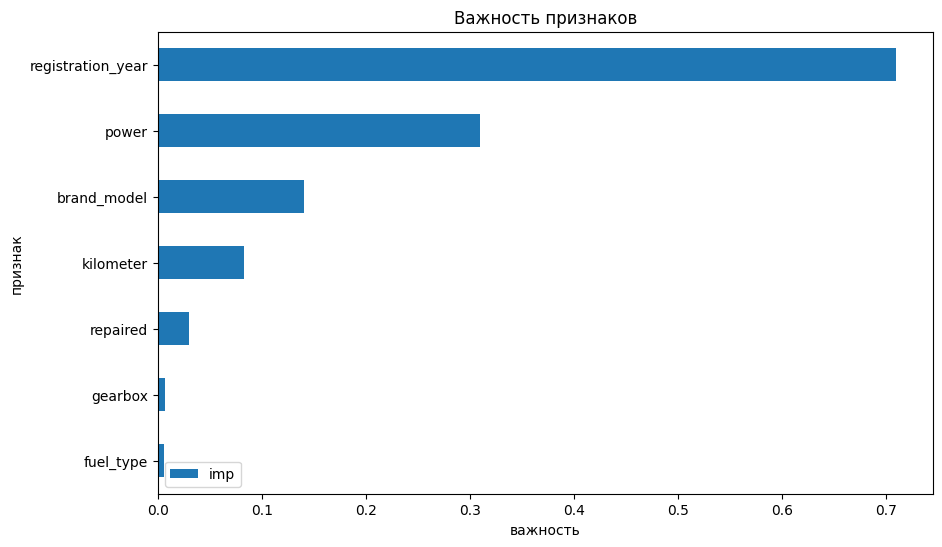

In [114]:
sorted_df = table.sort_values(by='imp',ascending =False)
print(sorted_df)

table.sort_values(by='imp')
table.sort_values(by='imp').plot(x='columns', y='imp', kind='barh', figsize=(10, 6))

plt.title('Важность признаков')
plt.xlabel('важность')
plt.ylabel('признак')
plt.show()

Наибольшую важность имеют признаки: год регистрации, мощность двигателя и модель. Наименее важные - тип топлива и коробка передач.

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP.

Рассчитаем SHAP значения.

In [115]:
#создание SHAP Explainer
explainer = shap.TreeExplainer(best_model_LGBM)

In [116]:
#расчет SHAP значений
shap_values = explainer(X_train, y_train)

Отобразим вклад каждого признака в классификацию всех наблюдений.
На оси X отложены значения Шепли, на оси Y — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP‑значений.

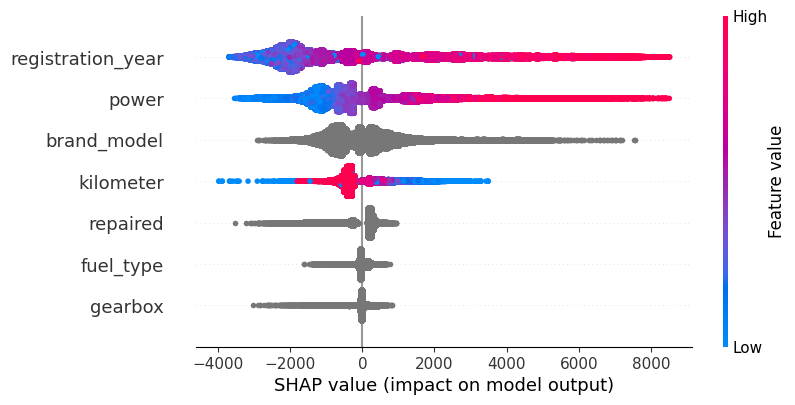

In [117]:
#визуализация вклада признаков в каждое предсказание модели
shap.plots.beeswarm(shap_values)

Построим столбчатую диаграмму, которая  отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю.

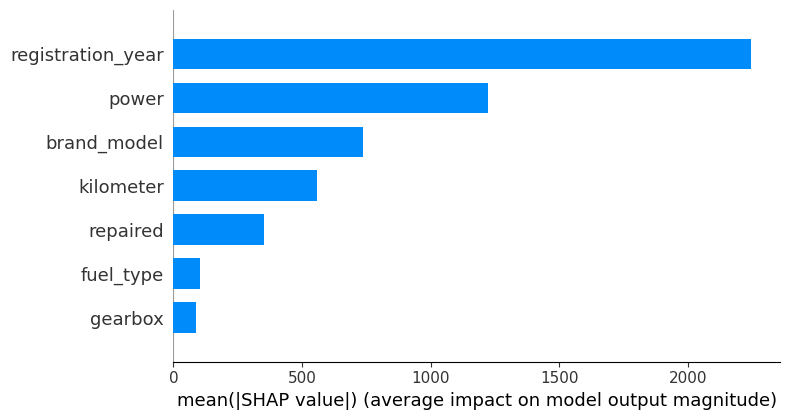

In [118]:
shap.summary_plot(shap_values,X_train,plot_type="bar")

Таким образом, SHAP выделил наиболее важными те же признаки, что и  permutation_importance.

# Заключение

Таким образом, решена задача регрессии для определения рыночной стоимости автомобиля  на основе входящих признаков: год регистрации автомобиля, марка, модель,
мощность двигателя, тип кузова и коробки передач, пробег, вид топлива,
почтовый индекс владельца, дата скачивания анкеты из базы.

Рассмотрены четыре различные модели:
DecisionTreeRegressor, SGDRegressor, CatBoost и LightGBM.

Для каждой модели с помощью случайного поиска с кросс-валидацией на 5 выборках проведен подбор гиперпараметров.
Выбор наилучшей модели произведен на основе сравнения валидационных метрик RSME.

Лучшей по метрике оказалась LightGBM, а по времени обучения и предсказания - DecisionTreeRegressor.

Для лучшей модели проведен анализ остатков.

С помощью метода permutation_importance и SHAP выявлены признаки, наиболее значимые для модели.
Наибольшую важность для модели имеют признаки: год регистрации, мощность двигателя и модель.
Наименее важные - тип топлива и коробка передач.